# Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
%matplotlib inline
np.random.seed(551)

# Helper Functions & Classes (For Both KNN & Decision Tree)

In [2]:
# KNN implementation
class KCrossValidation:
    def __init__(self, k_value=5):
        self.k = k_value

    def split(self, data_size):
        total = list(range(data_size))
        step = int(data_size / self.k) + 1
        sets = []
        for i in range(0, data_size, step):
            sets.append(total[i: i + step])
        result = []
        for i in range(len(sets) - 1, -1, -1):
            validation_set = sets[i]
            training_set = [sets[x] for x in range(len(sets) - 1, -1, -1) if x != i]
            training_set = [item for sublist in training_set for item in sublist]
            result.append((training_set, validation_set))
        return result

In [ ]:
def distribution(df,y):
    # use crosstable to display the distribution when analyzing the correlation between 2 categorical attributes
    
    for f in df.columns:
        print(f)
        if f==y:
            continue
        count=pd.crosstab(df[f], df[y])
        #display(count)
        count.T.plot(kind='bar')
        plt.title('{} & income'.format(f))
        plt.show()

In [ ]:
# split into train and validation(8:2)
def cross_validate(n_instances):
    # split the data
    each_fold = n_instances // 5
    inds = np.random.permutation(n_instances)
    #inds = []
    for f in range(5):
        #validation indices
        val_inds = list(range(f*each_fold, (f+1)*each_fold))
        #train indices
        train_inds = []
        if f > 0:
            train_inds = list(range(f*each_fold))
        if f < 5 - 1:
            train_inds = train_inds + list(range((f+1)*each_fold, n_instances))
        
        #The yield statement suspends function’s execution and sends a value back to the caller
        #but retains enough state information to enable function to resume where it is left off
        yield train_inds, val_inds

In [ ]:
#define a function for the MSE loss
loss = lambda y, yh: np.mean((y-yh)**2)

In [ ]:
#Plot the mean square error for different K values stored in K_list

def decision_tree(n_instances):
    K_list = range(1,30)
    n_folds = 5
    #err_tr, err_valid, acc_tr, acc_valid = np.zeros(len(K_list),5), np.zeros((len(K_list), 5)),np.zeros(len(K_list),5), np.zeros((len(K_list), 5))
    mse_tr, mse_val = np.zeros((len(K_list),5)), np.zeros((len(K_list),5))
    acc = np.zeros((len(K_list),5))
    for i, K in enumerate(K_list):
        #Find the validation errors for num_folds splits for a given K
        for f, (train, val) in enumerate(cross_validate(n_instances)):
            #create decision tree classifier
            tree = DecisionTreeClassifier(max_depth=K, criterion='entropy')

            #train 
            classifier = tree.fit(X.iloc[train], Y.iloc[train])
           
            #predict on the validation set
            ypred_val = classifier.predict(X.iloc[val])
            ytest_val = Y.iloc[val]
            #err_valid[i,f] = loss(ytest_val, ypred_val)
            #acc_valid[i,f] = accuracy_score(ytest_val, ypred_val)
            mse_val[i,f] = loss(ytest_val, ypred_val)
            #prediction on the training set
            ypred_tr = classifier.predict(X.iloc[train])
            ytest_tr = Y.iloc[train]
            #err_tr[i,f] = loss(ytest_tr, ypred_tr)
            #acc_tr[i,f] = accuracy_score(ytest_tr, ypred_tr)
            mse_tr[i,f] = loss(ytest_tr, ypred_tr)
            acc[i,f] = accuracy_score(ytest_val, ypred_val)
    #return err_tr, err_valid, acc_tr, acc_valid
    return mse_tr, mse_val,acc
    

In [ ]:
def plot_k(mse_tr, mse_val):
    K_list=range(1,30)
    
    plt.plot(K_list, np.mean(mse_tr,axis=1),marker='o',label='Training Error')
    plt.plot(K_list, np.mean(mse_val,axis=1),marker='D',label='Validation Error')
    plt.xlim(0,30)
    plt.ylim(0,0.5)
    plt.legend()
    plt.xlabel('K = maxdepth')
    plt.ylabel('Mean squared error (MSE)')
    plt.title('Maxdepth & Prediction error')
    plt.show()
def plot_acc(acc, title):
    K_list=range(1,30)
    
    plt.plot(K_list, np.mean(acc,axis=1),marker='o')
    plt.xlim(0,30)
    plt.ylim(0,1)
    plt.xlabel('K = maxdepth')
    plt.ylabel('accuracy')
    plt.title('Sample_size & accuracy')
    plt.show()

In [ ]:
# Check the effect of sample size
def check_size(total):
    print(total)
    unit_size = total//5
    print(unit_size)
    sample_size = 0
    for i in range(1,6):
        pct = int(100/5*i)
        if i==5:
            print('\n========={}% of the data========='.format(pct))
            #err_tr, err_valid,acc_tr, acc_valid=decision_tree(total)
            #plot(err_tr, err_valid,acc_tr, acc_valid,total)
            mse_tr, mse_val, acc = decision_tree(total)
            plot_k(mse_tr, mse_val,total)
            plot_acc(acc)
        else: # 0<=i<=4
            print('\n========={}% of the data========='.format(pct))
            #err_tr, err_valid,acc_tr, acc_valid=decision_tree(i*unit_size)
            #plot(err_tr, err_valid,acc_tr, acc_valid, i*unit_size)
            mse_tr, mse_val, acc = decision_tree(i*unit_size)
            plot_k(mse_tr, mse_val,i*unit_size)
            plot_acc(acc)

In [ ]:
#k*=6
def decision_tree_size(n_instances, depth):
    unit = n_instances//10
    mse_tr, mse_val = np.zeros((10,5)), np.zeros((10,5))
    acc = np.zeros((10,5))
    for i in range(10):
        size = (i+1) * unit
        
        for f, (train, val) in enumerate(cross_validate(size)):
            
            #create decision tree classifier
            tree = DecisionTreeClassifier(max_depth=depth)

            #train 
            classifier = tree.fit(X.iloc[train], Y.iloc[train])
           
            #predict on the validation set
            ypred_val = classifier.predict(X.iloc[val])
            ytest_val = Y.iloc[val]
            mse_val[i,f] = loss(ytest_val, ypred_val)
            
            #prediction on the training set
            ypred_tr = classifier.predict(X.iloc[train])
            ytest_tr = Y.iloc[train]
            
            mse_tr[i,f] = loss(ytest_tr, ypred_tr)
            acc[i,f] = accuracy_score(ytest_val, ypred_val)
            
    return mse_tr, mse_val, acc

def plot_size(mse_tr, mse_val,unit):
    sizes = (np.arange(10)+1)*unit
    
    plt.plot(sizes, np.mean(mse_tr,axis=1),marker='o',label='Training Error')
    plt.plot(sizes, np.mean(mse_val,axis=1),marker='D',label='Validation Error')
    plt.xlim(0,11*unit)
    plt.ylim(0.1,0.4)
    plt.legend()
    plt.xticks(sizes,rotation=-45)
    plt.xlabel('Sample size')
    plt.ylabel('Mean squared error (MSE)')
    plt.title('Sample size & Prediction error')
    plt.show()


In [ ]:
# apply the best model on the test set, and check the accuracy
def best_tree(depth, xtrain, ytrain, xtest, ytest):
    tree = DecisionTreeClassifier(max_depth=depth,criterion='entropy')
    #train 
    classifier = tree.fit(xtrain , ytrain)   
    #predict on the validation set
    ypred = classifier.predict(xtest)
    acc = accuracy_score(ytest, ypred)
    mse = loss(ytest, ypred)
    print('Prediction accuracy on the test set = {}\nMSE on the test set = {}'.format(acc,mse))

# The Adult Dataset

## KNN

### Preliminary cleanings

In [3]:
# Import the test & training datasets
training = pd.read_csv("adult.data", header=None, skipinitialspace=True)            # Skip the whitespaces after commas
test = pd.read_csv("adult.test", header=None, skiprows=1, skipinitialspace=True)

# Set column names
training.columns = test.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]

# display(training.head())

Drop all the rows with '?' in them

In [4]:
# Drop the rows with '?' in them
for col in training.columns:
    training = training[training[col] != '?']
    test = test[test[col] != '?']

# Restore the index (back to consecutive numbers)
training.index, test.index = np.arange(training.shape[0]), np.arange(test.shape[0])

# print(test.shape)
# print(training.shape)

### Feature Preparations

In [5]:
# Map continuous features into catagorical ones
def map_edu(x):
    # print(x)
    if x in ('Preschool', '1st-4th','5th-6th', '7th-8th'):
        return 'under MS-grad' 
    if x in ('11th','9th', '10th','12th'):
        return 'under HS-grad' 
    if x in ('HS-grad'):
        return 'HS-grad' 
    if x in ('Prof-school','Assoc-voc' ,'Assoc-acdm', 'Some-college' ):
        return 'college' 
    if x in ('Bachelors'):
        return 'Bachelors' 
    if x in ('Masters'):
        return 'Masters' 
    if x in ('Doctorate'):
        return 'Doctorate' 

def map_age(x):
    if x <= 25:
        return'Young' 
    if x >= 26 and x <= 45:
        return 'Middle_aged' 
    if x >= 46 and x <= 65:
        return 'Senior' 
    if x >= 66:
        return 'Old' 

def map_hours_per_week(x):
    # print(x)
    if x <= 25:
        return 'Part-time' 
    if x > 25 and x <= 40:
        return 'Full-time' 
    if x > 40 and x <= 60:
        return 'Over-time' 
    if x > 60:
        return 'Too-much' 

def map_cap_gain(x):
    if x == 0:
        return 'None' 
    if x > 0 and x <= 2333.25:
        return 'under Q1' 
    if x > 2333.25 and x <= 3572.5:
        return 'Q1-Q2' 
    if x > 3572.5 and x <= 6756:
        return 'Q2-Q3'
    if x > 6756:
        return 'over Q3'

def map_cap_loss(x):
    if x == 0:
        return 'None'
    if x > 0 and x <= 1581.75:
        return 'under Q1' 
    if x > 1581.75 and x <= 1862:
        return 'Q1-Q2' 
    if x > 1862 and x <= 2244:
        return 'Q2-Q3' 
    if x > 2244:
        return 'over Q3' 

training['age'] = training['age'].map(map_age)
training['education'] = training['education'].map(map_edu)
training['hours_per_week'] = training['hours_per_week'].map(map_hours_per_week)
training['capital_gain'] = training['capital_gain'].map(map_cap_gain)
training['capital_loss'] = training['capital_loss'].map(map_cap_loss)

test['age'] = test['age'].map(map_age)
test['education'] = test['education'].map(map_edu)
test['hours_per_week'] = test['hours_per_week'].map(map_hours_per_week)
test['capital_gain'] = test['capital_gain'].map(map_cap_gain)
test['capital_loss'] = test['capital_loss'].map(map_cap_loss)

cols = ["age", "workclass", "fnlwgt", "education", "education_num",
        "marital_status", "occupation", "relationship", "race", "sex",
        "capital_gain", "capital_loss", "hours_per_week", "native_country"]

# Data set
encoder = OneHotEncoder()

training = training.replace('Holand-Netherlands', np.nan).dropna(how='any')
age = encoder.fit_transform(training[['age']]).toarray()
workclass = encoder.fit_transform(training[['workclass']]).toarray()
education = encoder.fit_transform(training[['education']]).toarray()
marital_status = encoder.fit_transform(training[['marital_status']]).toarray()
occupation = encoder.fit_transform(training[['occupation']]).toarray()
relationship = encoder.fit_transform(training[['relationship']]).toarray()
race = encoder.fit_transform(training[['race']]).toarray()
sex = encoder.fit_transform(training[['sex']]).toarray()
capital_gain = encoder.fit_transform(training[['capital_gain']]).toarray()
capital_loss = encoder.fit_transform(training[['capital_loss']]).toarray()
hours_per_week = encoder.fit_transform(training[['hours_per_week']]).toarray()
native_country = encoder.fit_transform(training[['native_country']]).toarray()


data_features = np.array([np.concatenate((age[i], workclass[i],
                           education[i], marital_status[i], occupation[i],
                           relationship[i], race[i], sex[i], capital_gain[i],
                           capital_loss[i], hours_per_week[i], native_country[i]), axis=None)
                           for i in range(len(age))])

data_labels = encoder.fit_transform(training[['income']]).toarray()

# Test Set
encoder = OneHotEncoder()
age = encoder.fit_transform(test[['age']]).toarray()
workclass = encoder.fit_transform(test[['workclass']]).toarray()
education = encoder.fit_transform(test[['education']]).toarray()
marital_status = encoder.fit_transform(test[['marital_status']]).toarray()
occupation = encoder.fit_transform(test[['occupation']]).toarray()
relationship = encoder.fit_transform(test[['relationship']]).toarray()
race = encoder.fit_transform(test[['race']]).toarray()
sex = encoder.fit_transform(test[['sex']]).toarray()
capital_gain = encoder.fit_transform(test[['capital_gain']]).toarray()
capital_loss = encoder.fit_transform(test[['capital_loss']]).toarray()
hours_per_week = encoder.fit_transform(test[['hours_per_week']]).toarray()
native_country = encoder.fit_transform(test[['native_country']]).toarray()

test_features = np.array([np.concatenate((age[i], workclass[i],
                           education[i], marital_status[i], occupation[i],
                           relationship[i], race[i], sex[i], capital_gain[i],
                           capital_loss[i], hours_per_week[i], native_country[i]), axis=None)
                           for i in range(len(age))])

test_labels = encoder.fit_transform(test[['income']]).toarray()

### Experimentations

Find the optimal K

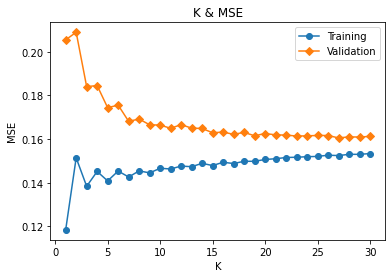

In [10]:
kf = KCrossValidation()

scores_train = np.zeros(30)
scores_val = np.zeros(30)
for train_indices, validation_indices in kf.split(len(training)):
    train_features = data_features[train_indices]
    train_labels = data_labels[train_indices]
    validation_features = data_features[validation_indices]
    validation_labels = data_labels[validation_indices]
    for k in range(1, 31):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_features, train_labels)

        validation_prediction = model.predict(validation_features)
        score_val = mean_squared_error(validation_labels, validation_prediction)
        scores_val[k - 1] += score_val

        train_prediction = model.predict(train_features)
        score_train = mean_squared_error(train_labels, train_prediction)
        scores_train[k - 1] += score_train


scores_val /= 5         # Divide all of the calculated accuracies by 5, since K = 5
scores_train /= 5

x = np.arange(30) + 1
plt.plot(x, scores_train, marker='o', label='Training')
plt.plot(x, scores_val, marker='D', label='Validation')
plt.xlabel('K')
plt.ylabel('MSE')
plt.title("K & MSE")
plt.legend()
plt.show()

Find the relationships between data size and MSE

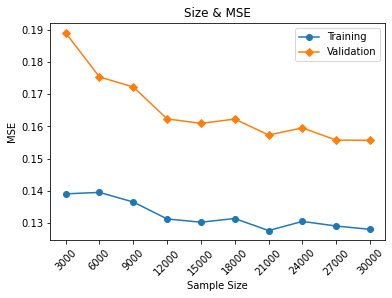

In [7]:
mse_train_on_sizes = np.zeros(10)
mse_val_on_sizes = np.zeros(10)
kf = KCrossValidation()
for i in range(1, 11):
    # Take 3000 * i samples each time
    sample = np.random.choice([n for n in range(30161)], 3000 * i)
    for train_indices, validation_indices in kf.split(3000 * i):
        train_features = data_features[sample[train_indices]]
        train_labels = data_labels[sample[train_indices]]
        validation_features = data_features[sample[validation_indices]]
        validation_labels = data_labels[sample[validation_indices]]
        model = KNeighborsClassifier(n_neighbors=7)
        model.fit(train_features, train_labels)

        validation_prediction = model.predict(validation_features)
        mse_val = mean_squared_error(validation_labels, validation_prediction)
        mse_val_on_sizes[i - 1] += mse_val

        train_prediction = model.predict(train_features)
        mse_train = mean_squared_error(train_labels, train_prediction)
        mse_train_on_sizes[i - 1] += mse_train

mse_train_on_sizes /= 5
mse_val_on_sizes /= 5

x = (np.arange(10) + 1) * 3000
plt.plot(x, mse_train_on_sizes, marker='o', label='Training')
plt.plot(x, mse_val_on_sizes, marker='D', label='Validation')
plt.xlabel('Sample Size')
plt.xticks(x, rotation=45)
plt.ylabel('MSE')
plt.title("Size & MSE")
plt.legend()
plt.show()

Apply the optimal K to the test set

In [13]:
best = KNeighborsClassifier(n_neighbors=7)
best.fit(data_features, data_labels)
best_prediction = best.predict(test_features)
best_accuracy = accuracy_score(test_labels, best_prediction)
best_mse = mean_squared_error(test_labels, best_prediction)
print(f'Prediction Accuracy On Test Set: {best_accuracy}\nMSE On Test Set: {best_mse}')

Prediction Accuracy On Test Set: 0.8255644090305445
MSE On Test Set: 0.17443559096945552


## Decision Tree

### Data Processing

In [ ]:
np.random.seed(123)

## modify the features
def map_edu(x):
    if x in ('Preschool', '1st-4th','5th-6th', '7th-8th'):
        return 'under MS-grad' 
    if x in ('11th','9th', '10th','12th'):
        return 'under HS-grad' 
    if x in ('HS-grad'):
        return 'HS-grad' 
    if x in ('Prof-school','Assoc-voc' ,'Assoc-acdm', 'Some-college' ):
        return 'college' 
    if x in ('Bachelors'):
        return 'Bachelors' 
    if x in ('Masters'):
        return 'Masters' 
    if x in ('Doctorate'):
        return 'Doctorate' 

def map_age(x):
    if x <= 25:
        return'Young' 
    if x>=26 and x<=45:
        return 'Middle_aged' 
    if x>=46 and x<=65:
        return 'Senior' 
    if x>=66:
        return 'Old' 
def map_hours_per_week(x):
    if x<=25:
        return 'Part-time' 
    if x>25 and x<=40:
        return 'Full-time' 
    if x>40 and x<=60:
        return 'Over-time' 
    if x>60:
        return 'Too-much' 
    return h
def map_cap_gain(x):
    if x==0:
        return 'Zero' 
    if x>0 and x<=2333.25:
        return 'under Q1' 
    if x>2333.25 and x<=3572.5:
        return 'Q1-Q2' 
    if x>3572.5 and x<=6756:
        return 'Q2-Q3'
    if x>6756:
        return 'over Q3'
def map_cap_loss(x):
    if x==0:
        return 'Zero'
    if x>0 and x<=1581.75:
        return 'under Q1' 
    if x>1581.75 and x<=1862:
        return 'Q1-Q2' 
    if x>1862 and x<=2244:
        return 'Q2-Q3' 
    if x>2244:
        return 'over Q3' 

In [ ]:
test = pd.read_csv('adult.test',header=None, skiprows=1, skipinitialspace=True)
test = pd.DataFrame(test)
df = pd.read_csv('adult.data',header=None, skipinitialspace=True)
df = pd.DataFrame(df)
df.columns = test.columns = ["age", "workclass", "fnlwgt", "education", "education_num",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country", "income"]
df = df.replace('?', np.nan)
df = df.dropna(how='any')
df = df.replace('<=50K',0)
df = df.replace('>50K',1)
#before dropping: 32561; after dropping: 30162
total = len(df)
df['education']=df['education'].map(map_edu)
df['hours_per_week']=df['hours_per_week'].map(map_hours_per_week)
df['capital_gain']=df['capital_gain'].map(map_cap_gain)
df['capital_loss']=df['capital_loss'].map(map_cap_loss)
df['age'] = df['age'].map(map_age)

test = test.replace('?',np.nan)
test = test.dropna(how='any')
test = test.replace('<=50K.',0)
test = test.replace('>50K.',1)
test['education']=test['education'].map(map_edu)
test['hours_per_week']=test['hours_per_week'].map(map_hours_per_week)
test['capital_gain']=test['capital_gain'].map(map_cap_gain)
test['capital_loss']=test['capital_loss'].map(map_cap_loss)
test['age'] = test['age'].map(map_age)
print(len(df))

30162


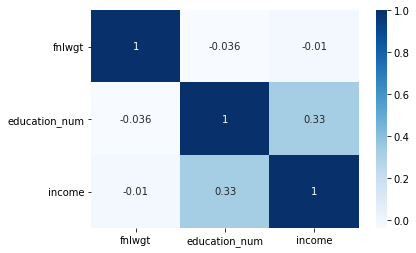

In [ ]:
df.corr()
sns.heatmap(df.corr('spearman'), annot=True, cmap='Blues')
plt.show()

### Feature Selection

In [ ]:
#split dataset in features and target variable
#remove: education_num, fnlwgt, 
feature_cols = ["age", "workclass","education",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country"]
features = ["age", "workclass","education",
                                   "marital_status", "occupation", "relationship", "race", "sex",
                                   "capital_gain", "capital_loss", "hours_per_week", "native_country","income"]
df = df[features]
#distribution(df,'income')

In [ ]:
X = df[feature_cols] # Features
#Y = pd.get_dummies(df.income, columns='income')# Target variable
Y = df.income

test = test.replace('?',np.nan)
test = test.dropna(how='any')

x_test = test[feature_cols]
y_test = test.income

#encoder = OneHotEncoder()
#X = encoder.fit_transform(X).toarray()

X = pd.get_dummies(X, columns=["age","workclass",  "education","capital_gain","capital_loss","hours_per_week",
                     "marital_status", "occupation", "relationship", "race", "sex", "native_country"])
x_test = pd.get_dummies(x_test, columns=["age","workclass",  "education","capital_gain","capital_loss","hours_per_week",
                     "marital_status", "occupation", "relationship", "race", "sex", "native_country"])
X = X.drop(columns='native_country_Holand-Netherlands')

X = pd.DataFrame(X)

In [ ]:
for c in df.columns:
    print('\n=====column:{}======'.format(c))
    print(df[c].unique())


=====column:age======
['Middle_aged' 'Senior' 'Young' 'Old']

=====column:workclass======
['State-gov' 'Self-emp-not-inc' 'Private' 'Federal-gov' 'Local-gov'
 'Self-emp-inc' 'Without-pay']

=====column:education======
['Bachelors' 'HS-grad' 'under HS-grad' 'Masters' 'college' 'under MS-grad'
 'Doctorate']

=====column:marital_status======
['Never-married' 'Married-civ-spouse' 'Divorced' 'Married-spouse-absent'
 'Separated' 'Married-AF-spouse' 'Widowed']

=====column:occupation======
['Adm-clerical' 'Exec-managerial' 'Handlers-cleaners' 'Prof-specialty'
 'Other-service' 'Sales' 'Transport-moving' 'Farming-fishing'
 'Machine-op-inspct' 'Tech-support' 'Craft-repair' 'Protective-serv'
 'Armed-Forces' 'Priv-house-serv']

=====column:relationship======
['Not-in-family' 'Husband' 'Wife' 'Own-child' 'Unmarried' 'Other-relative']

=====column:race======
['White' 'Black' 'Asian-Pac-Islander' 'Amer-Indian-Eskimo' 'Other']

=====column:sex======
['Male' 'Female']

=====column:capital_gain======
[

### Model Training

#### Effect of the hyperparameters

In [ ]:
mse_tr, mse_val, acc = decision_tree(total)

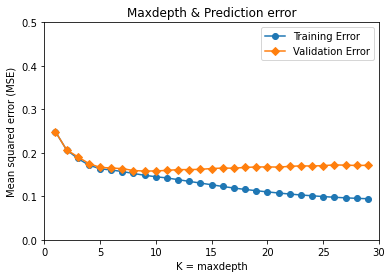

In [ ]:
plot_k(mse_tr, mse_val)

#### Effect of the sample size

In [ ]:
print(min(np.mean(mse_val,axis=1)))
print(np.mean(mse_val,axis=1))
#when maxdepth = 7, mse is the minimum value

0.15789124668435014
[0.24890584 0.20699602 0.1910809  0.17543103 0.16647878 0.16498674
 0.16359416 0.15921751 0.15789125 0.15848806 0.15925066 0.16110743
 0.16143899 0.16200265 0.16409151 0.16515252 0.16535146 0.16657825
 0.16747347 0.16714191 0.16657825 0.16833554 0.16926393 0.16942971
 0.17015915 0.17082228 0.17204907 0.17085544 0.17198276]


In [ ]:
depth = 9
mse_tr, mse_val, acc = decision_tree_size(total,depth)

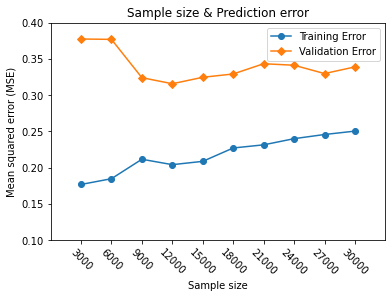

In [ ]:
plot_size(mse_tr, mse_val,3000)

#### Apply the model on the test set

In [ ]:
best_tree(9, X,Y,x_test, y_test)

Prediction accuracy on the test set = 0.8445551128818061
MSE on the test set = 0.1554448871181939


# The Vehicle Dataset

## KNN

### Data Cleaning
<font size=4>Clean those data such that all Nan rows will be removed.</font>

In [ ]:
np.random.seed(551)

# Since the attributes 'car' are NaN for most of data, we removed it here
cols = list(range(0, 26))
cols.remove(14)

# Load the dataset as a DataFrame
data = pd.read_csv("in-vehicle-coupon-recommendation.csv", header=0, usecols=cols)

# Reset the column name to make more sense
data.columns = ["destination", "passenger", "weather", "temperature",
                "time", "coupon", "expiration", "gender", "age",
                "maritalStatus", "has_Children", "education",
                "occupation", "income",
                "Bar", "CoffeeHouse",
                "CarryAway", "RestaurantLessThan20",
                "Restaurant20To50", "toCoupon_GEQ15min", "toCoupon_GEQ5min",
                "toCoupon_GEQ25min", "direction_same",
                "direction_opp", "whether_accepted"]

# Drop all rows with NaN value
for col in data.columns:
    data = data[data[col].notna()]

# Map the age to be categorical variable
def map_age(x):
    if x == 'below21':
        return 'below 21'
    if x in range(21, 30):
        return '21-29'
    if x in range(31, 40):
        return '31-39'
    if x in range(40, 50):
        return '40-50'
    if x == '50plus':
        return '50+'
    
data['age'] = data['age'].map(map_age)

# reset the index from 0
data.index = np.arange(data.shape[0])

### Split into Training and Test Dataset

In [ ]:
# Split the data to training set and test set, the test set will take size of 15 percent
training_set, test_set = train_test_split(data, test_size=0.15)

# reset the index from 0
training_set.index, test_set.index = np.arange(training_set.shape[0]), np.arange(test_set.shape[0])

### Prepare the Training Set and Training Labels

In [ ]:
encoder = OneHotEncoder()

# display(training_set)

destination = encoder.fit_transform(training_set[['destination']]).toarray()
passenger = encoder.fit_transform(training_set[['passenger']]).toarray()
weather = encoder.fit_transform(training_set[['weather']]).toarray()
time = encoder.fit_transform(training_set[['time']]).toarray()
coupon = encoder.fit_transform(training_set[['coupon']]).toarray()
expiration = encoder.fit_transform(training_set[['expiration']]).toarray()
gender = encoder.fit_transform(training_set[['gender']]).toarray()
age = encoder.fit_transform(training_set[['age']]).toarray()
maritalStatus = encoder.fit_transform(training_set[['maritalStatus']]).toarray()
has_Children = np.array(training_set[['has_Children']])
education = encoder.fit_transform(training_set[['education']]).toarray()
occupation = encoder.fit_transform(training_set[['occupation']]).toarray()
income = encoder.fit_transform(training_set[['income']]).toarray()
Bar = encoder.fit_transform(training_set[['Bar']]).toarray()
CoffeeHouse = encoder.fit_transform(training_set[['CoffeeHouse']]).toarray()
CarryAway = encoder.fit_transform(training_set[['CarryAway']]).toarray()
RestaurantLessThan20 = encoder.fit_transform(training_set[['RestaurantLessThan20']]).toarray()
Restaurant20To50 = encoder.fit_transform(training_set[['Restaurant20To50']]).toarray()
toCoupon_GEQ15min = np.array(training_set[['toCoupon_GEQ15min']])
toCoupon_GEQ5min = np.array(training_set[['toCoupon_GEQ5min']])
toCoupon_GEQ25min = np.array(training_set[['toCoupon_GEQ25min']])
direction_same = np.array(training_set[['direction_same']])
data_features = np.array([np.concatenate((destination[i], passenger[i], weather[i],
                                          time[i], coupon[i],
                                          expiration[i], expiration[i], gender[i],
                                          age[i], maritalStatus[i], has_Children[i],
                                          education[i], occupation[i], income[i],
                                          Bar[i], CoffeeHouse[i], CarryAway[i],
                                          RestaurantLessThan20[i], Restaurant20To50[i],
                                          toCoupon_GEQ15min[i], toCoupon_GEQ5min[i],
                                          toCoupon_GEQ25min[i], direction_same[i]), axis=None) for i in
                          range(len(age))])
data_labels = np.ravel(np.array(training_set[['whether_accepted']]))

### Using 5 Cross Validation

In [ ]:
kf = KCrossValidation(k_value=5)

### Training KNN Model to Pick the Optimal Value of K

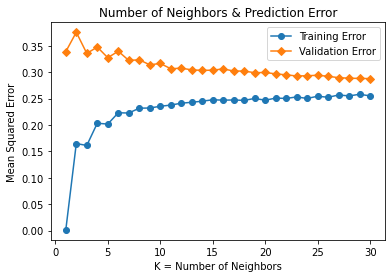

In [ ]:
scores_validations = [0] * 50
scores_training = [0] * 50
validation = 0
for train_indices, validation_indices in kf.split(training_set.shape[0]):
    train_features = data_features[train_indices]
    train_labels = data_labels[train_indices]
    validation_features = data_features[validation_indices]
    validation_labels = data_labels[validation_indices]

    validation += 1
    for k in range(1, 31):
        # print('Validation', validation, 'k', k)
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(train_features, train_labels)
        validation_prediction = model.predict(validation_features)
        train_prediction = model.predict(train_features)
        score_validation = mean_squared_error(validation_labels, validation_prediction)
        score_training = mean_squared_error(train_labels, train_prediction)
        scores_validations[k - 1] += score_validation
        scores_training[k - 1] += score_training
scores_validations = [scores_validations[x] / 5 for x in range(30)]
scores_training = [scores_training[x] / 5 for x in range(30)]

x = np.array(range(1, 31))
plt.plot(x, scores_training, marker='o', label='Training Error')
plt.plot(x, scores_validations, marker='D', label='Validation Error')
plt.xlabel('K = Number of Neighbors')
plt.ylabel('Mean Squared Error')
plt.title("Number of Neighbors & Prediction Error")
plt.legend()
plt.show()

### Set a Fix Value of K and Change the Size of Dataset

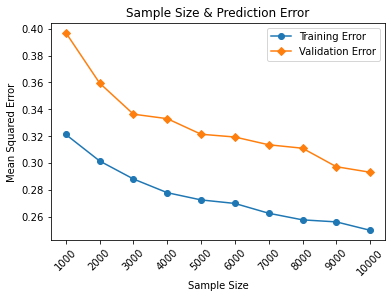

In [ ]:
scores_on_sizes_validation = np.zeros(10)
scores_on_sizes_training = np.zeros(10)

for i in range(1, 11):
    # Take 1000 * i samples each time
    sample = np.random.choice([n for n in range(10267)], 1000 * i)
    for train_indices, validation_indices in kf.split(1000 * i):
        train_features = data_features[train_indices]
        train_labels = data_labels[train_indices]
        validation_features = data_features[validation_indices]
        validation_labels = data_labels[validation_indices]
        model = KNeighborsClassifier(n_neighbors=20)
        model.fit(train_features, train_labels)
        validation_prediction = model.predict(validation_features)
        train_prediction = model.predict(train_features)
        score_validation = mean_squared_error(validation_labels, validation_prediction)
        score_training = mean_squared_error(train_labels, train_prediction)
        scores_on_sizes_validation[i - 1] += score_validation
        scores_on_sizes_training[i - 1] += score_training

scores_on_sizes_validation /= 5
scores_on_sizes_training /= 5

x = np.arange(10) + 1
plt.plot(x * 1000, scores_on_sizes_training, marker='o', label='Training Error')
plt.plot(x * 1000, scores_on_sizes_validation, marker='D', label='Validation Error')
plt.xlabel('Sample Size')
plt.ylabel('Mean Squared Error')
plt.xticks(x * 1000, rotation=45)
plt.title("Sample Size & Prediction Error")
plt.legend()
plt.show()

### Prepare the Test Set and Test Labels

In [ ]:
destination_t = encoder.fit_transform(test_set[['destination']]).toarray()
passenger_t = encoder.fit_transform(test_set[['passenger']]).toarray()
weather_t = encoder.fit_transform(test_set[['weather']]).toarray()
time_t = encoder.fit_transform(test_set[['time']]).toarray()
coupon_t = encoder.fit_transform(test_set[['coupon']]).toarray()
expiration_t = encoder.fit_transform(test_set[['expiration']]).toarray()
gender_t = encoder.fit_transform(test_set[['gender']]).toarray()
age_t = encoder.fit_transform(test_set[['age']]).toarray()
maritalStatus_t = encoder.fit_transform(test_set[['maritalStatus']]).toarray()
has_Children_t = np.array(test_set[['has_Children']])
education_t = encoder.fit_transform(test_set[['education']]).toarray()
occupation_t = encoder.fit_transform(test_set[['occupation']]).toarray()
income_t = encoder.fit_transform(test_set[['income']]).toarray()
Bar_t = encoder.fit_transform(test_set[['Bar']]).toarray()
CoffeeHouse_t = encoder.fit_transform(test_set[['CoffeeHouse']]).toarray()
CarryAway_t = encoder.fit_transform(test_set[['CarryAway']]).toarray()
RestaurantLessThan20_t = encoder.fit_transform(test_set[['RestaurantLessThan20']]).toarray()
Restaurant20To50_t = encoder.fit_transform(test_set[['Restaurant20To50']]).toarray()
toCoupon_GEQ15min_t = np.array(test_set[['toCoupon_GEQ15min']])
toCoupon_GEQ5min_t = np.array(test_set[['toCoupon_GEQ5min']])
toCoupon_GEQ25min_t = np.array(test_set[['toCoupon_GEQ25min']])
direction_same_t = np.array(test_set[['direction_same']])

test_features = np.array([np.concatenate((destination_t[i], passenger_t[i], weather_t[i],
                                          time_t[i], coupon_t[i],
                                          expiration_t[i], expiration_t[i], gender_t[i],
                                          age_t[i], maritalStatus_t[i], has_Children_t[i],
                                          education_t[i], occupation_t[i], income_t[i],
                                          Bar_t[i], CoffeeHouse_t[i], CarryAway_t[i],
                                          RestaurantLessThan20_t[i], Restaurant20To50_t[i],
                                          toCoupon_GEQ15min_t[i], toCoupon_GEQ5min_t[i],
                                          toCoupon_GEQ25min_t[i], direction_same_t[i]), axis=None) for i in range(len(age_t))])
test_labels = np.ravel(np.array(test_set[['whether_accepted']]))

### Use the Best Preformed Models to Predict the Test Set

In [ ]:
best = KNeighborsClassifier(n_neighbors=20)
best.fit(data_features, data_labels)
best_prediction = best.predict(test_features)
accuracy = accuracy_score(test_labels, best_prediction)
mse = mean_squared_error(test_labels, best_prediction)
print('Accuracy score', accuracy)
print('MSE', mse)

Accuracy score 0.7047461368653422
MSE 0.29525386313465785


## Decision Tree

### Data Preprocessing

In [ ]:
np.random.seed(123)

def map_age(x):
    if x == 'below21':
        return 'below 21'
    if x=='50plus' :
        return '50+'
    if int(x) in range(21,30):
        return '21-29'
    if int(x) in range(30,40):
        return '31-39'
    if int(x) in range(40,50):
        return '40-50'
    if int(x)<21:
        return 'below 21'
    else:
        return '50plus'

In [ ]:
#1. Delete temperature, car
#2. Catagorize age('below 21','21-30','31-40','41-50','50+')
df = pd.read_csv('in-vehicle-coupon-recommendation.csv')
df = pd.DataFrame(df)
print(len(df))
df = df.drop(columns=['car','temperature', 'direction_opp'])
df['age'] = df['age'].map(map_age)


12684


In [ ]:
df = df.replace('?', np.nan)
df = df.dropna(how='any')
total = len(df)
print(total)

12079


destination


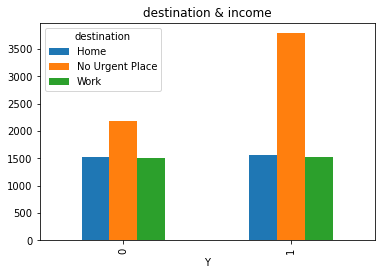

passanger


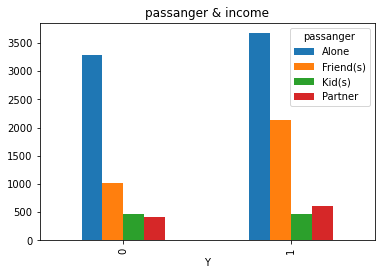

weather


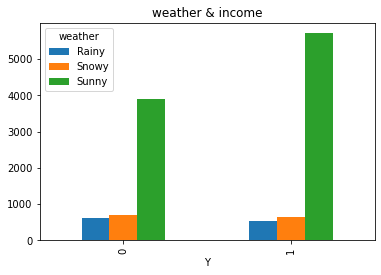

time


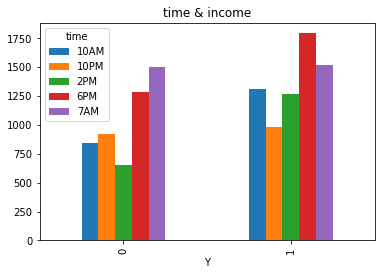

coupon


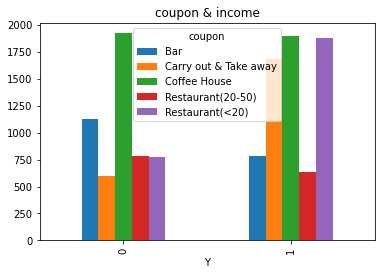

expiration


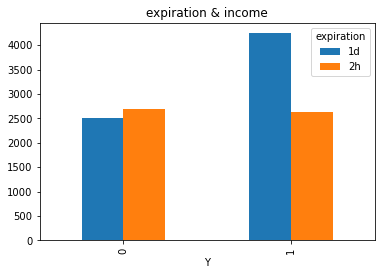

gender


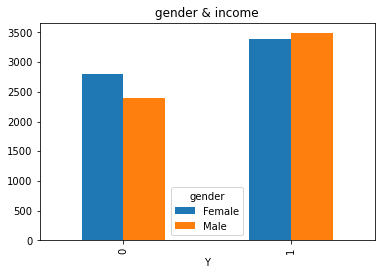

age


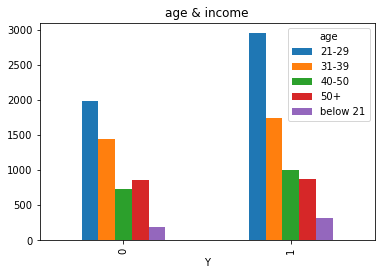

maritalStatus


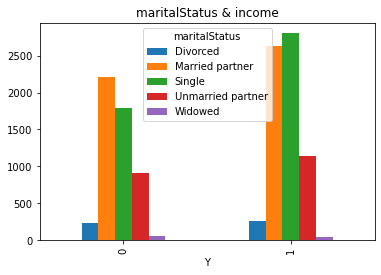

has_children


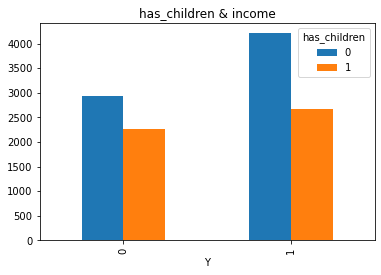

education


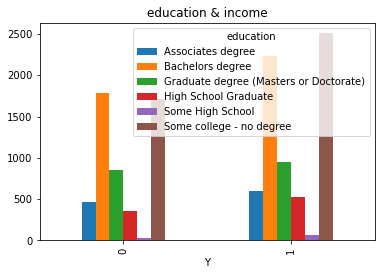

occupation


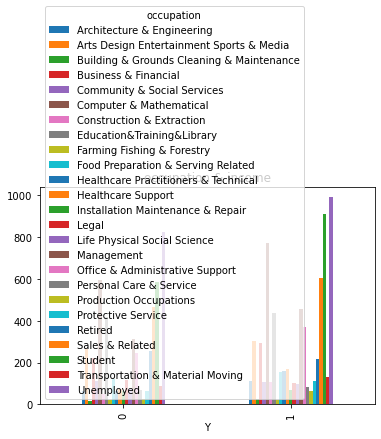

income


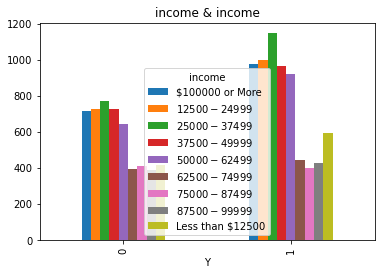

Bar


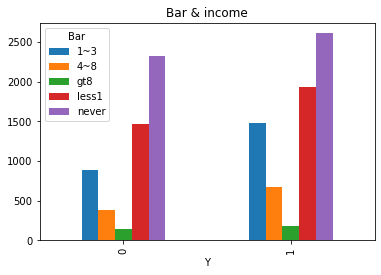

CoffeeHouse


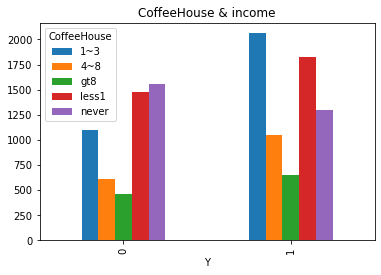

CarryAway


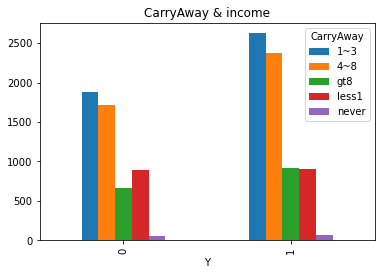

RestaurantLessThan20


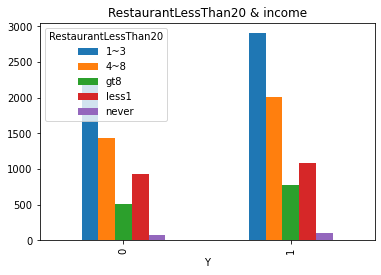

Restaurant20To50


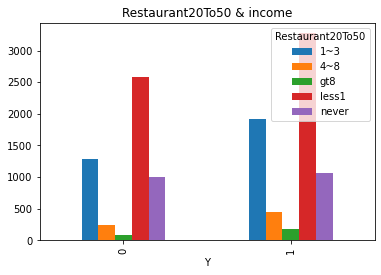

toCoupon_GEQ5min


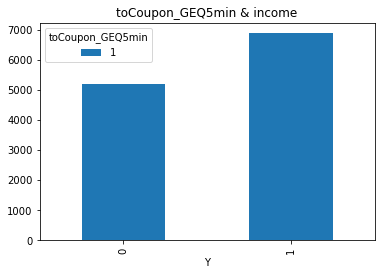

toCoupon_GEQ15min


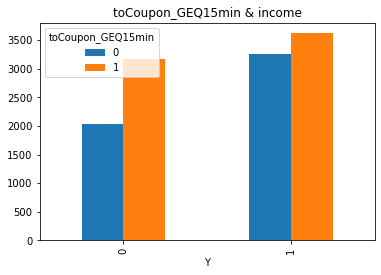

toCoupon_GEQ25min


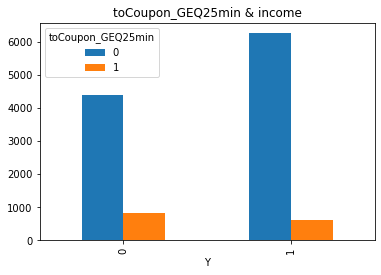

direction_same


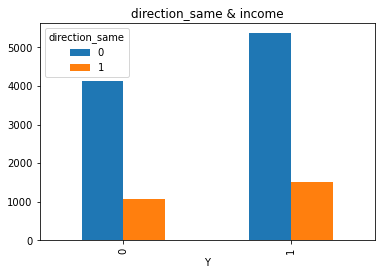

Y
12079


In [ ]:
#dataset = 15%validation + 85%trianing
inds = rand.permutation(total)
split = int(np.ceil(total*0.85))
features = ['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'has_children', 'education',
       'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same']
df1 = df[['destination', 'passanger', 'weather', 'time', 'coupon', 'expiration',
       'gender', 'age', 'maritalStatus', 'has_children', 'education',
       'occupation', 'income', 'Bar', 'CoffeeHouse', 'CarryAway',
       'RestaurantLessThan20', 'Restaurant20To50', 'toCoupon_GEQ5min',
       'toCoupon_GEQ15min', 'toCoupon_GEQ25min', 'direction_same','Y']]
distribution(df1,'Y')
X = df[features]
X = pd.get_dummies(X)
Y = df['Y']
train = list(range(split))
test = list(range(split, total))
x_tr = X.iloc[train]
y_tr = Y.iloc[train]
x_test = X.iloc[test]
y_test = Y.iloc[test]
print(len(x_tr)+len(x_test))

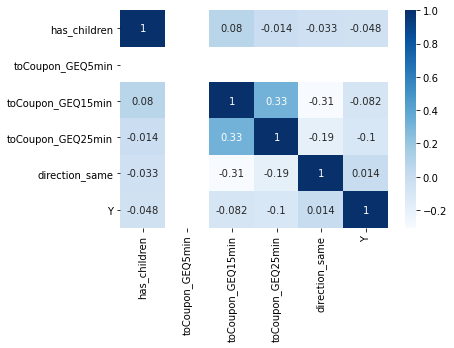

In [ ]:
df.corr()
sns.heatmap(df.corr(), annot=True, cmap='Blues')
plt.show()

### Model Training

#### Effect of the hyperparameters

In [ ]:
mse_tr, mse_val, acc = decision_tree(split)

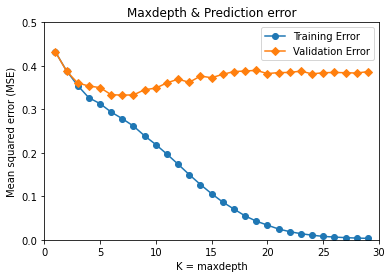

In [ ]:
plot_k(mse_tr, mse_val)

#### Effect of the sample size

In [ ]:
mean = np.mean(mse_val,axis=1)

In [ ]:
print(mean)
min(mean)

[0.43234291 0.38801754 0.36064296 0.35362884 0.35002435 0.33365806
 0.33268388 0.33317097 0.34515343 0.34875792 0.36093522 0.3693132
 0.36220166 0.37652216 0.37272284 0.38051632 0.38684851 0.38811495
 0.38967365 0.38217243 0.38451047 0.38480273 0.38792012 0.3814905
 0.38421822 0.38480273 0.38421822 0.38343887 0.3867511 ]


0.3326838772528008

In [ ]:
depth = 8
mse_tr, mse_val, acc = decision_tree_size(split, depth)

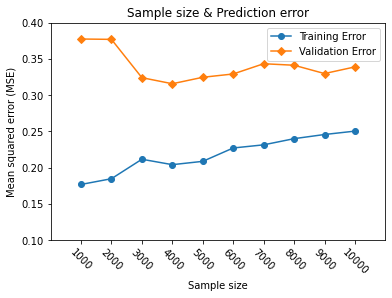

In [ ]:
plot_size(mse_tr,mse_val,1000)

#### Apply the best model on the test set

In [ ]:
best_tree(depth, x_tr, y_tr, x_test,y_test)

Prediction accuracy on the test set = 0.6339039204859194
MSE on the test set = 0.36609607951408063
